<a href="https://colab.research.google.com/github/mwvgroup/Pitt-Google-Broker/blob/u%2Ftjr%2Ftutorials/pgb_utils/tutorials/PGB_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitt-Google Broker Tutorial

| | Learning Objective | Section |
|---|---|---|
| 1. | Understand What, Where, How to access our ZTF data | 1) Introduction |
| 2. | Access our data | 3) BigQuery Database |
| | | 4) Files in Cloud Storage |
| 3. | Process our data | 5) Apache Beam data pipelines |

# Notebook Outline

1. Introduction
    - 1a. Data overview
    - 1b. `pgb_utils` overview
    - 1c. Note on costs

2. Setup

3. BigQuery Database
    - 3a. Python
        - Table names and schemas
        - Query lightcurves and other history
            - Plot a lightcurve
        - Cone Search
        - Direct access using `google.cloud.bigquery`
    - 3b. Command-line tool `bq`

4. Files in Cloud Storage
    - 4a. Python
        - Download files
        - Plot cutouts and lightcurves
    - 4b. Command-line tool `gsutil`

5. Apache Beam data pipelines
    - 5a. A demo example
    - 5b. Descriptions
    - 5c. Pitt-Google working examples
        - Lightcurve pipeline
        - Cone Search pipeline

---

# 1) Introduction

## 1a) Data overview

We are currently ingesting the [Zwicky Transient Facility](https://www.ztf.caltech.edu/) (ZTF) nightly alert stream and publishing various filtered and derived message streams. Our database and file storage contain data from alerts since ~November 2020.
All Pitt-Google Broker data is public and hosted by [Google Cloud Platform](https://cloud.google.com/) (GCP).

__Data Access__:

All data and resources can be accessed via Google's [Cloud SDK](https://cloud.google.com/sdk) by way of the command-line, Python, and many other languages.
In addition, we are developing the `pgb_utils` Python package which provides convience functions for common tasks such as querying the database for lightcurves or cone searches, decoding, plotting, and processing the data.
This tutorial demonstrates access via the command-line (Cloud SDK) and Python (Cloud SDK, `pgb_utils`).

In order to make API calls you will need to create a Cloud project that is associated with your Google account.
The Setup section of the tutorial will walk you through this.
You do not need to enable billing for this tutorial; everything we do will fall under the "Free Tier".
Some notes on pricing are included in relevant sections below. 

__Data Products__:

- Databases ([BigQuery](https://cloud.google.com/bigquery))
    - query for:
        - alerts (except cutouts)
        - object lightcurves and other history
        - cone searches

- File storage ([Cloud Storage](https://cloud.google.com/storage))
    - download the complete, original alert packets in Avro format, including cutouts

- Message streams ([Pub/Sub](https://cloud.google.com/pubsub/docs/overview)) (covered in a future tutorial)
    - streams include:
        - ZTF stream: complete
        - ZTF stream: filtered for purity
        - ZTF stream: filtered for likely extragalactic transients
        - ZTF stream + Salt2 fits (for likely extragalactic transients)

---

## 1b) `pgb_utils` overview

`pgb_utils` is a collection of helper functions to facilitate interaction with Pitt-Google Broker data. The tutorial will demonstrate its use. The package is essentially a set of:

1. Convience wrappers for the [Google Cloud Python SDK](https://cloud.google.com/python/docs/reference)
2. Helper functions for decoding and plotting ZTF data, provided by ZTF (see [Filtering_alerts.ipynb](https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb))
3. Helper functions for running [Apache Beam](https://beam.apache.org/) pipelines

You are encouraged to look at and alter the source code to learn how to use the underlying methods yourself.

Modules and their functionality include:

- `pgb_utils.beam`
    - helper functions for running Apache Beam data pipelines

- `pgb_utils.bigquery`
    - view dataset, table, and schema information
    - query: lightcurves
    - query: cone search
    - cast query results to a `pandas.DataFrame` or `json` formatted string.

- `pgb_utils.figures`
    - plot lightcurves
    - plot cutouts

- `pgb_utils.utils`
    - general utilities such as data type casting


---

## 1c) Note on costs

Google Cloud's pricing structure is "pay-as-you-go". 
Most services include a [Free Tier](https://cloud.google.com/free) monthly allotment. 
For example, when querying BigQuery, the price is $5.00 per TB of data processed, and your first 1 TB per month is free. 

_You do not need to setup billing for this tutorial; everything we do will remain well within the Free Tier(*)._
If you wish to become a power-user in the future, you may need to [create a billing account](https://support.google.com/cloud/answer/6293499#enable-billing). See also: 
- [pricing structure](https://cloud.google.com/pricing) (scroll to "Only pay for what you use")
- [detailed price list](https://cloud.google.com/pricing/list) (search for "BigQuery", "Cloud Storage", "Pub/Sub"); 
- [pricing calculator](https://cloud.google.com/products/calculator?skip_cache=true) (same search as above)

(*) The Free Tier for Cloud Storage is limited to US regions. We are interested in feedback from users outside the US on the behavior of that section of this tutorial for you. Please see the "Files in Cloud Storage" section of this tutorial for details. 

---

# 2) Setup

1. Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to create a GCP project. Take note of the auto-generated "Project ID", you will need it below in order to make API calls.
    - If you work outside of Colab you may need to:
        - enable APIs for your project: [BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery); 
        - [setup authentication](https://cloud.google.com/docs/authentication/getting-started)

2. Installs, imports, etc.:

In [1]:
from google.colab import auth

In [2]:
auth.authenticate_user()
# follow the instructions to authorize Google Cloud SDK 

In [4]:
pgb_project_name = 'pitt-google-broker-prototype'
pgb_project_id = 'ardent-cycling-243415'

In [5]:
# ENTER YOUR GCP PROJECT ID HERE

my_project_id = 

In [6]:
# Create a function to run and print a shell command.
def run(cmd: str):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

In [7]:
# Install some packages/versions not included with Colab
# 
packages = ['apache-beam','google-apitools','APLpy',
            'beautifulsoup4==4.8',  # plot_cutouts grayscale stretch='arcsinh'
            'astropy-healpix==0.6',  # plot_cutouts grayscale stretch='arcsinh'
            'astropy==3.2.1',  # plot_cutouts grayscale stretch='arcsinh'
            ]
# --DEBUG
# 'google-cloud-pubsub',] 
# causes:
# `ContextualVersionConflict: (PyYAML 3.13 (/usr/local/lib/python3.7/dist-packages), Requirement.parse('pyyaml>=5.2'), {'libcst'})`
# when importing apache-beam below.
# --DEBUG

for package in packages:
    run(f'pip install --quiet {package}')
# it may complain about some version conflicts but it should not cause problems.

# Note: Outside of Colab you should use `pip install apache-beam[gcp]`
# to get Beam's Google Cloud Platform tools.

>> pip install --quiet apache-beam
     |████████████████████████████████| 9.0MB 10.5MB/s 
     |████████████████████████████████| 829kB 53.7MB/s 
     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 153kB 53.5MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 2.2MB 45.2MB/s 
     |████████████████████████████████| 17.7MB 209kB/s 
     |████████████████████████████████| 112kB 63.3MB/s 
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.

>> pip install --quiet google-apitools
     |████████████████████████████████| 174kB 12.7MB/s 

>> pip install --quiet APLpy
     |████████████████████████████████| 92kB 4.2MB/s 
     |

In [8]:
# Install the Pitt-Google Broker utilities package
run('python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils')

# This is currently on the test.pypi servers. I should publish to the actual
# PyPI soon, but I'd like some code review first.

>> python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils
Looking in indexes: https://test.pypi.org/simple/



In [9]:
import apache_beam as beam
import aplpy
from astropy import coordinates as coord
from astropy import units as u
from astropy.io import fits
import fastavro
from google.colab import drive
import gzip
import io
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
# import warnings

from google.cloud import bigquery, storage
# , pubsub

import pgb_utils as pgb

In [10]:
# Connect your Google Drive file system
# to be used in the sections on File Storage and Apache Beam pipelines
drive.mount('/content/drive') 
# follow the instructions to authorize access

# create a path for later
colabpath = '/content/drive/MyDrive/Colab\ Notebooks/PGB'
colabpath_noesc = '/content/drive/MyDrive/Colab Notebooks/PGB'
run(f'mkdir -p {colabpath}')

# Colab Hint: Click the "Files" icon on the left to view a file browser.

# Colab Hint: Click the "Code snippets" icon (<>) on the left and search for 
#       "access drive" to learn how to interact with Drive.

Mounted at /content/drive
>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB



---

# 3) BigQuery Database

Some links if you're interested. Otherwise, skip down to the code.

- [Overview of querying BigQuery data](https://cloud.google.com/bigquery/docs/query-overview)

- [Intro to BigQuery API Client Libraries](https://cloud.google.com/bigquery/docs/reference/libraries) (includes [Python](https://googleapis.dev/python/bigquery/latest/index.html), Java, C#, Go, Node.js, PHP, and Ruby)

- [BigQuery How-to guides](https://cloud.google.com/bigquery/docs/how-to). There are many! Here are some of note:
    - [Introduction to interacting with BigQuery](https://cloud.google.com/bigquery/docs/interacting-with-bigquery)

    - [Queries](https://cloud.google.com/bigquery/docs/running-queries) (covered in this tutorial)

    - [Writing query results to your own BigQuery table](https://cloud.google.com/bigquery/docs/writing-results#permanent-table) (also see other sections on that page)

    - [Export table data to a file in Google Cloud Storage](https://cloud.google.com/bigquery/docs/exporting-data)
        - Note the [Exporting data stored in BigQuery](https://cloud.google.com/bigquery/docs/exporting-data#exporting_data_stored_in) section of that page.

    - [Best practices](https://cloud.google.com/bigquery/docs/how-to#best-practices) (e.g., Controlling costs, Optimizing query performance)

- Other Colab tutorials:

    - [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb)

- Pricing:
    - [Overview of BigQuery pricing](https://cloud.google.com/bigquery/pricing)
        - [Query pricing](https://cloud.google.com/bigquery/docs/query-overview#query_pricing). Query charges are based on number of bytes processed. The first 1 TB of data processed per month, per billing account, is free. Beyond this, the price is $5.00 per TB.
        - [Storage pricing](https://cloud.google.com/bigquery/pricing#storage). The first 10 GB of BigQuery storage per month is free (you only pay for tables you create in your own project).

    - [Using cached query results](https://cloud.google.com/bigquery/docs/cached-results)
        - BigQuery writes all query results to a temporary (~24 hours), cached results table (unless you explicitly specify a destination table). When you run a duplicate query, BigQuery attempts to reuse cached results. If it is successful, you are not charged for the query.

## 3a) Python

- [Python Client Documentation](https://googleapis.dev/python/bigquery/latest/index.html)
- [Colab Snippets](https://colab.research.google.com/notebooks/snippets/bigquery.ipynb#scrollTo=jl97S3vfNHdz) (more examples)

### Table names and schemas

In [11]:
# Create a Client for the BigQuery connections below
pgb.bigquery.create_client(my_project_id)
# this is just a convenience wrapper, as are many pgb functions. look at
# its source code for guidance on using `google.cloud` libraries directly.

# Colab Hint: Mouse over the function name to see its definition and
#             source code (make sure the cell is selected).


Instantiating a BigQuery client with project_id: ardent-cycling-243415



In [12]:
pgb.bigquery.get_dataset_table_names()

['salt2', 'candidates', 'alerts']

In [ ]:
pgb.bigquery.get_table_info('candidates')

# Colab Hint: Right-click this cell and select "Copy to scratch cell"
#             so you can use this as a reference in later queries.

---

### Query lightcurves and other history

In [15]:
# Choose the history data you want returned
columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'candidates' table
# pgb.bigquery.get_table_info('candidates')

In [14]:
# Choose specific objects (optional. we'll choose some to minimize load time)
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

To retrieve lightcurves and other history, we must query for the objects' "candidate" observations and aggregate the results by `objectId`.
- `pgb.bigquery.query_objects()` is a convenience wrapper for this.
It's options are demonstrated below. 
- You can also use `pgb.bigquery.object_history_sql_statement()` to get the required SQL statement and make the query yourself. See the "Using `google.cloud.bigquery` directly" section.

In [ ]:
# Option 1: Get a single DataFrame of all results

lcs_df = pgb.bigquery.query_objects(columns, objectIds=objectIds)
# This will execute a dry run and tell you how much data will be processed.
# You will be asked to confirm before proceeding.
# In the future we'll skip this using
dry_run = False

lcs_df.sample(10)
# cleaned of duplicates

Congratulations! You've now retrieved your first data from the transient table. 
It is a DataFrame containing the candidate observations for every object we requested, indexed by `objectId` and `candid` (candidate ID). It includes the columns we requested in the query.

`fid` is the filter, mapped to an integer. You can see the filter's common name in the table schema we looked at earlier, or you can use `pgb.utils.ztf_fid_names()` which returns a dictionary of the mapping.

In [25]:
fid_names = pgb.utils.ztf_fid_names()  # dict
print(fid_names)

lcs_df['filter'] = lcs_df['fid'].map(fid_names)
lcs_df.head()

{1: 'g', 2: 'R', 3: 'i'}


jd  fid     magpsf  sigmapsf filter
objectId     candid                                                            
ZTF18aczuwfe 1440303993415015003  2.459195e+06    2  19.807590  0.159926      R
             1440322513415015004  2.459195e+06    1  19.819330  0.127621      g
             1442328323415015002  2.459197e+06    1  19.782700  0.172808      g
             1444285643415015001  2.459199e+06    2  19.927372  0.209740      R
             1449226053415015000  2.459204e+06    2  19.965925  0.170471      R

If you want to iterate over individual objects instead of loading all the data at once, `query_objects()` can return a generator:

In [ ]:
# Option 2: Get a generator that yields a DataFrame for each objectId

iterator = True
objects = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     iterator=iterator,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates

for lc_df in objects:
    print(f'\nobjectId: {lc_df.objectId}')  # objectId in metadata
    print(lc_df.sample(5))

Each DataFrame contains data on a single object, and is indexed by `candid`. The `objectId` is in the metadata.

`query_objects()` can also return a json formatted string of the query results:

In [ ]:
# Option 3: Get a single json string with all the results

format = 'json'
lcsjson = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     format=format,
                                     dry_run=dry_run
                                     )
                                     # cleaned of duplicates
print(lcsjson)

# read it back in
df = pd.read_json(lcsjson)
df.head()

In [ ]:
# Option 4: Get a generator that yields a json string for a single objectId

format = 'json'
iterator = True
jobj = pgb.bigquery.query_objects(columns, 
                                  objectIds=objectIds, 
                                  format=format, 
                                  iterator=iterator,
                                  dry_run=dry_run
                                  )
                                  # cleaned of duplicates

for lcjson in jobj:
    print(lcjson)
    # lc_df = pd.read_json(lcjson)  # read back to a df

Finally, `query_objects()` can return the raw query job object that it gets from its API call using `google.cloud.bigquery`'s `query()` method.

In [ ]:
# Option 5: Get the `query_job` object
#           (see the section on using google.cloud.bigquery directly)

query_job = pgb.bigquery.query_objects(columns, 
                                       objectIds=objectIds, 
                                       format='query_job',
                                       dry_run=dry_run
                                       )
# query_job is iterable
# each element contains the aggregated history for a single objectId
# Beware: this has not been cleaned of duplicate entries

In [ ]:
# Option 5 continued: parse query_job results row by row

for row in query_job:
    # values can be accessed by field name or index
    print(f"objectId={row[0]}, magpsf={row['magpsf']}")

    # pgb can cast to a DataFrame or json string
    # this option also cleans the duplicates
    lc_df = pgb.bigquery.format_history_query_results(row=row)
    print(f'\nobjectId: {lc_df.objectId}')  # objectId in metadata
    print(lc_df.head(1))
    lcjson = pgb.bigquery.format_history_query_results(row=row, format='json')
    print('\n', lcjson)

    break

---

#### Plot a lightcurve

In [27]:
# Get an object's lightcurve DataFrame with the minimum required columns
columns = ['jd','fid','magpsf','sigmapsf','diffmaglim']
objectId = 'ZTF20acqgklx'
lc_df = pgb.bigquery.query_objects(columns, objectIds=[objectId], dry_run=False)

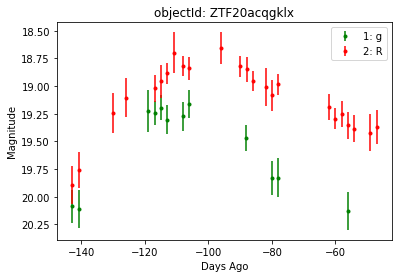

In [28]:
# make the plot
pgb.figures.plot_lightcurve(lc_df, objectId=objectId)
# this function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

---

### Cone Search

To perform a cone search, we query for object histories and then check whether they are within the cone. 
`pgb.bigquery.cone_search()` is a convenience wrapper for this.

First we set the search parameters.

In [29]:
center = coord.SkyCoord(76.91, 6.02, frame='icrs', unit='deg')
radius = coord.Angle(2, unit=u.deg)

columns = ['jd', 'fid', 'magpsf', 'sigmapsf']
# 'objectId' and 'candid' will be included automatically
# options are in the 'candidates' table
# pgb.bigquery.get_table_info('candidates')
dry_run = False

# we'll restrict to a handful of objects to reduce runtime, but this is optional
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

`cone_search()` has similar options to `query_objects()`:

In [30]:
# Option 1: Get a single df of all objects in the cone

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           dry_run=dry_run
                                           )
objects_in_cone.sample(5)

sigmapsf         ra  ...  fid       dec
objectId     candid                                    ...               
ZTF18aczuwfe 1477168703415015002  0.211510  77.496707  ...    2  5.387562
ZTF20acqgklx 1444320905215015016  0.131236  76.633648  ...    1  7.760110
             1442282165215015017  0.146518  76.633643  ...    2  7.760036
ZTF18aczuwfe 1477214243415015002  0.200380  77.496838  ...    1  5.387240
ZTF20acqgklx 1416400905215015017  0.163898  76.633719  ...    2  7.760113

[5 rows x 6 columns]

In [ ]:
# Option 2: Get a single json string of all objects in the cone
format = 'json'

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           dry_run=dry_run
                                           )
objects_in_cone

In [ ]:
# Option 3: Get a generator that yields dfs of individual objects in the cone
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(f'objectId: {obj.objectId}')  # objectId in metadata
    print(obj.head())

In [ ]:
# Get a generator that yields a json string of individual objects in the cone
format = 'json'
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(obj)

---

### Direct access using `google.cloud.bigquery`

The previous sections demonstrated convenience wrappers for querying with `google.cloud.bigquery`. Here we demonstrate using these tools directly with some basic examples. View `pgb_utils` source code for more examples.

Links to more information:
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [`google.cloud.bigquery` docs](https://googleapis.dev/python/bigquery/latest/index.html)

Query setup:

In [ ]:
# Create a BigQuery Client to handle the connections
bq_client = bigquery.Client(project=my_project_id)

In [ ]:
# Write the standard SQL query statement

# pgb.bigquery.get_dataset_table_names()  # view available tables
# pgb.bigquery.get_table_info('<table>')  # view available column names

# construct the full table name
table = 'salt2'
dataset = 'ztf_alerts'
full_table_name = f'{pgb_project_id}.{dataset}.{table}'

# construct the query
query = (
    f'SELECT objectId, candid, t0, x0, x1, c, chisq, ndof '
    f'FROM `{full_table_name}` '
    f'WHERE ndof>0 and chisq/ndof<2 '
)

# note: if you want to query object histories you can get the
# query statement using `pgb.bigquery.object_history_sql_statement()`

In [ ]:
# Let's create a function to execute a "dry run"
# and tell us how much data will be processed.
# This is essentially `pgb.bigquery.dry_run()`
def dry_run(query):
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    query_job = bq_client.query(query, job_config=job_config)
    nbytes, TB = query_job.total_bytes_processed, 1e12
    print(f'\nQuery statement:')
    print(f'\n"{query}"\n')
    print(f'will process {nbytes} bytes of data.')
    print(f'({nbytes/TB*100:.3}% of your 1 TB Free Tier monthly allotment.)')

In [ ]:
# Find out how much data will be processed
dry_run(query)

Query:

In [ ]:
# Make the API request
query_job = bq_client.query(query)
# Beware: the results may contain duplicate entries

Format and view results:

In [ ]:
# Option 1: dump results to a pandas.DataFrame
df = query_job.to_dataframe()

# some things you might want to do with it
df = df.drop_duplicates()
df = df.set_index(['objectId','candid']).sort_index()

df.hist()
df.head()

In [ ]:
# Option 2: parse results row by row
for r, row in enumerate(query_job):
    
    # row values can be accessed by field name or index
    print(f"objectId={row[0]}, t0={row['t0']}")
    
    if r>5: break

---

## 3b) Command-line tool `bq`

All commands in this section are executed using the `run` function we created earlier to run commands on the command-line.

`bq`'s default dialect is legacy SQL. Here we use standard SQL by passing `--use_legacy_sql=false`.
<!-- (see [change to standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Quickstart using the bq command-line tool](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-command-line)
- [Reference of all `bq` commands and flags](https://cloud.google.com/bigquery/docs/reference/bq-cli-reference)
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)

In [ ]:
# Get help
run('bq help query')

In [ ]:
# view the schema of a table
run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.candidates')
# run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.alerts')

# Note: The first time you make a call with `bq` you will ask you to 
# initialize a .bigqueryrc configuration file. Follow the directions.

In [ ]:
# Query: dry run

# first we do a dry_run by including the flag --dry_run
bq_query = """bq query \
--dry_run \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)
# Note: to execute this directly in the command-line, enter everything 
# contained within the triple quotes.

In [ ]:
# Query

bq_query = """bq query \
--use_legacy_sql=false \
'SELECT 
    objectId, candid, t0, x0, x1, c, chisq, ndof
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
LIMIT
    10'
"""

run(bq_query)

---

# 4) Files in Cloud Storage

I plan to rename the files and the bucket before the workshop as follows:
- old bucket: `ardent-cycling-243415_ztf_alert_avro_bucket`
- new bucket: `ardent-cycling-243415_ztf_alert_avros`
- old files: `{ztf_topic}_{kafka_timestamp}.avro`
- new files: `{objectId}.{candid}.{ztf_topic}.avro`
---

- Pricing
    - [Cloud Storage pricing](https://cloud.google.com/storage/pricing)
        - [Free Tier](https://cloud.google.com/storage/pricing#cloud-storage-always-free) includes >=5000 operations per month, but is limited to US regions(*). Standard operations are $0.004-$0.05 per 10,000 operations (depending on type).

(*) We are interested in feedback from users outside the US on the behavior of this section of this tutorial for you. You can send feedback to troy.raen@pitt.edu.

## 4a) Python

- [Python Client documentation](https://googleapis.dev/python/storage/latest/client.html)

### Download files

Download alerts from a given night

In [31]:
night = 20210404  # yyyymmdd. ENTER YOUR DATE
bucket_name = f'{pgb_project_id}_ztf_alert_avro_bucket'

# Create a client and request a list of files
storage_client = storage.Client(my_project_id)
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=f'ztf_{night}', delimiter='/')

In [32]:
# download the files
for b, blob in enumerate(blobs):
    local_path = f'{colabpath_noesc}/{blob.name}'
    blob.download_to_filename(local_path)

    if b>5:
        break

### Plot cutouts and lightcurves

Open a file
(see the previous section to download files)

In [ ]:
paths = Path(colabpath_noesc).glob('*.avro')
for path in paths:
    with open(path, 'rb') as fin:
        alert_list = [r for r in fastavro.reader(fin)]
    break
alert_dict = alert_list[0]  # extract the single alert packet

print(alert_dict.keys())
print(alert_dict.candidate.keys())

Plot cutouts

In [ ]:
pgb.figures.plot_cutouts(alert_dict)
# this function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

Cast to a dataframe and plot lightcurves

In [ ]:
dflc = pgb.utils.alert_dict_to_dataframe(alert_dict)
pgb.figures.plot_lightcurve(dflc)
# both functions were adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb


Plot everything together

In [ ]:
pgb.figures.plot_lightcurve_cutouts(alert_dict)


## 4b) Command-line tool `gsutil`

- [Quickstart: Using the gsutil tool](https://cloud.google.com/storage/docs/quickstart-gsutil)
- [`gsutil cp` - Copy files and objects](https://cloud.google.com/storage/docs/gsutil/commands/cp)

In [ ]:
# Get help
# run('gsutil help')
run('gsutil help cp')

Download a single file

In [ ]:
run(f'gsutil cp gs://ardent-cycling-243415_ztf_alert_avro_bucket/ztf_20210401_programid1_1617259046498.avro {colabpath}/.')

---

# 5) Apache Beam data pipelines

[Apache Beam](https://beam.apache.org/) is an SDK that facilitates writing and executing data pipelines. Our Pitt-Google Broker uses Beam to run our data-processing pipelines on the ZTF alert stream. The [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/) is very useful.

In this section of the tutorial, we will demonstrate and describe batch-mode Beam pipelines, and provide working examples that read from our BigQuery database and execute a pipeline with template functions that you can play with.

_Note on streaming_: The cores of these pipelines (the pipeline minus the input and output functions) can also be plugged directly into an input function that reads data from our Pub/Sub streams and then executes in streaming mode, writing to a sink that accepts streaming data, like Pub/Sub or BigQuery. In this tutorial we will make some comments regarding streaming pipelines where applicable, but the details are left for a future tutorial. In the meantime, please contact us with questions.

_Note on environments_: We will execute pipelines directly in Colab, but the same pipelines can be executed on a local machine or various distributed systems using different "runners". 
For example, see 
[Apache Flink](https://beam.apache.org/documentation/runners/flink/), 
[Apache Spark](https://beam.apache.org/documentation/runners/spark/), 
[Google Dataflow](https://beam.apache.org/documentation/runners/dataflow/), and
[DirectRunner](https://beam.apache.org/documentation/runners/direct/) (the last being the default, which we use below).
The user sets a few configurations and the runner does the work of executing the pipeline, managing the required environments and resources (e.g., VM's) and distributing the work.

---

## 5a) A demo example

To demonstrate the basic steps of an Apache Beam pipeline, we'll create one that counts the words in Shakespeare's King Lear and then filters for low-frequency words.
Adapted from [this notebook](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-py.ipynb).

Streaming note: [here is an example](https://beam.apache.org/documentation/sdks/python-streaming/) that modifies a similar word-counting pipeline for streaming input via Pub/Sub. Note that "windowing" is only required because this example aggregates elements in the pipeline (by counting the frequency of each word). This is not necessary in order to, for example, process each lightcurve.

In [ ]:
import re

Setup: create some paths and download a copy of King Lear

In [ ]:
kinglearpath = f'{colabpath}/kinglear'
kinglearpath_noesc = f'{colabpath_noesc}/kinglear'
run(f'mkdir -p {kinglearpath}')
run(f'mkdir -p {kinglearpath}/outputs')

# download the text file
run(f'gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt {kinglearpath}/')

# Colab Hint: Click the "Files" icon on the left to view a file browser.

Define and run the pipeline.

This example will give you an idea about what it possible by demonstrating the use of several different Apache Beam functions that operate on the data in various ways.
However, don't worry about the details here.
Steps labeled 1, 2, and 3 in the code are described further in the following subsection. Working examples that connect to our data sources will follow.

Note that some [operators are overloaded](https://stackoverflow.com/questions/43796046/explain-apache-beam-python-syntax):
- `|` means `apply`
- `>>` allows you to name the step with the preceeding string. It is optional. We use it here to improve readability. Various UIs like Dataflow use it in their displays.

In [ ]:
input_pattern = f'{kinglearpath_noesc}/*'
outputs_prefix = f'{kinglearpath_noesc}/outputs/part'

# 0. Instantiate a pipeline object
with beam.Pipeline() as pipeline:
  (
    # 1. Start the pipeline by piping it to a "read" function
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(input_pattern)

    # 2. PROCESS THE DATA.
    #    These `lambda` functions are simple examples of user-defined functions 
    #    applied to the output of the previous transformation in various ways.
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Filter for counts < 10' >> beam.Filter(lambda x: x[1]<10)

    # 3. Format and output the results
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

You have just run an Apache Beam data pipeline! Let's look at the first 20 results. Beware, there are no ordering guarantees.

In [ ]:
outputs_prefix_esc = f'{kinglearpath}/outputs/part'
run('head -n 20 {}-00000-of-*'.format(outputs_prefix_esc))

Final note: Here we have simply chained the pipeline steps together, but the output of each transformation is an immutable collection that we can assign to a variable and pipe in to multiple transforms, as in this code fragment:

```python
      king_lear = (
          pipeline | 'Read lines' >> 
          beam.io.ReadFromText(input_pattern)
      )
      word_counts = (
          king_lear | 'Count words' >>
          <... count words ...>
      )
      sentence_counts = (
          king_lear | 'Count sentences' >>
          <... count sentences ...>
      )
```

---

## 5b) Descriptions

Here we describe 3 basic steps of Beam pipelines, and their related functions, in a way that is specific to the "Pitt-Google working examples" that follow. These general steps are labeled in the code of the demo example above.

1. __Read data__

Here is a table of Beam's [Built-in I/O Transforms](https://beam.apache.org/documentation/io/built-in/). We will use one to read data from BigQuery.

`ReadFromBigQuery()` ([docs](https://beam.apache.org/releases/pydoc/2.25.0/apache_beam.io.gcp.bigquery.html#apache_beam.io.gcp.bigquery.ReadFromBigQuery)):

Output: 
- Elements are `google.cloud.bigquery` query rows, which we discussed in the "BigQuery Database" section. 
    - In our example pipelines below, we will cast these to DataFrames using a class in `pgb_utils.beam`, which is a simple wrapper for the function in `pgb_utils.bigquery` that does the type casting.

Parameter options (see docs for complete list):
- `query`: to read in the results of a SQL query, pass in the query as a string. See the "BigQuery Database" section of this tutorial for some examples.
- `table`: to read in an entire table, pass in the full table name as `'PROJECT:DATASET.TABLE'`. See the "BigQuery Database" section of this tutorial for options.
- `gcs_location`: the table or query results will be extracted and written to temporary Avro files to be processed by the pipeline (this happens in the background). Colab does not allow users to write these (often large) files to its system, so we use this parameter to specify a Google Cloud Storage location instead. Pitt-Google Broker is providing a bucket for this purpose _for the duration of the workshop_. It is set in the examples' configs below.
- `use_standard_sql`: `True` to use BigQuery's standard SQL dialect. (default `False`)
- `validate`: `True` to perform some checks prior to pipeline execution. `False` (default) to skip them.

Streaming note: use `ReadFromPubSub()` ([docs](https://beam.apache.org/releases/pydoc/2.25.0/apache_beam.io.gcp.pubsub.html#apache_beam.io.gcp.pubsub.ReadFromPubSub))

2. __Process the data__

We will use of 2 of the available methods, which covers many use cases. Here, we describe them. In the next section, we will provide working examples that you can use as templates. See the demo example above and the [Beam programming guide](https://beam.apache.org/documentation/programming-guide/) for options beyond these two.

- [`beam.Filter()` method](https://beam.apache.org/documentation/transforms/python/elementwise/filter/): 
    - A. Define your `my_filter()` function. It should:    
        - accept a single object from the collection defined by the previous step in the pipeline (e.g., a lightcurve dataframe)
        - return `True` or `False`, where `False` means the object will be dropped
    - B. Apply it using `beam.Filter(my_filter)`

- [`beam.ParDo()` method](https://beam.apache.org/documentation/transforms/python/elementwise/pardo/) for generic parallel processing:
    - A. Define your processing function. You must call it `process()`. It should:
        - accept a single object from the input collection
        - return a list of one or more objects (all of the same type) that will become elements in the resulting output collection
    - B. Wrap your function in a class, `my_processing()` (call it whatever you'd like). This should be a child class of `beam.DoFn`.
    - C. Apply it to the input collection using `beam.ParDo(my_processing())`

Some things to keep in mind:
- The output from each step in the pipeline is an imutable _collection_ of objects.
    - When we chain our pipeline steps, we are piping the output collection from a given function to the input of the function that follows it. Alternately, we could assign each output to a variable, and then explicitely pipe it in to one or more of any functions that follow it. See the final note in the demo example above.
- User-defined functions should accept and operate on a _single_ object (for example, the lightcurve or history associated with a unique `objectId`). 
    - Note that whether the pipeline is operating in batch or streaming mode makes no difference to user-defined functions.



3. __Write the results__

Here is a table of Beam's [Built-in I/O Transforms](https://beam.apache.org/documentation/io/built-in/). There are many. Your favorite option is likely to be supported. We will use one to simply write results to a file.

`beam.io.WriteToText()` ([docs](https://beam.apache.org/releases/pydoc/2.25.0/apache_beam.io.textio.html#apache_beam.io.textio.WriteToText)):

Input:
- we can pipe in inputs of many different types (though the elements in a single input collection must all be of the same type).

Parameter options (see docs for complete list):
- `file_path_prefix`: output files will be written to a path beginning with this prefix, followed by a shard identifier.

---

## 5c) Pitt-Google working examples

In these examples, we will query the database for object histories and cast them to DataFrames, apply a filter and a processing function, and write the results to a text file.

First, let's define a filter and a processing function.
Both will take as input `lc_df`, a single object's lightcurve (or history) DataFrame.
_The functions will work as-is, or you can use them as templates to create your own._

_Colab Hint_: Right-click on one of the code cells with a function definition and select "Copy to scratch cell". Use the new scratch cell to change the function and experiment with the pipeline.

In [ ]:
# Filter for likely solar system objects

def nearby_ssobject(lc_df):
    """Keep only objects that are within 5" of a known solar system object.
    To be called with `beam.Filter(nearby_ssobject)`.
    """

    ssdistnr = lc_df['ssdistnr'].mean()
    ssobject_is_near = (ssdistnr > 0) and (ssdistnr < 5)

    return ssobject_is_near
    # generally: return a bool where `True` means we keep this df, else drop it

In [ ]:
# Processing: Calculate and return the mean magnitude per passband

class calc_mean_mags(beam.DoFn):
    """Class that wraps our `process()` function to calculate mean magnitudes.
    To be called with `beam.ParDo(calc_mean_mags())`.
    """

    def process(self, lc_df):
        """Calculate mean magnitudes per passband."""

        meanmags = lc_df[['fid','magpsf']].groupby('fid').mean()

        # we will write this to a file, so let's format it nicely
        output = []
        for fid, row in meanmags.iterrows():
            output.append(f"{lc_df.objectId},{fid},{row['magpsf']}")

        return output
        # generally: return a list containing 0 or more elements, each of which
        # becomes an element in the `ParDo`'s output collection.

Now let's configure and run specific pipelines.

### Lightcurve pipeline

Set configs

See the "BigQuery Database" section for options in generating the query statement.

Use `pgb.bigquery.get_table_info('candidates')` in a scratch cell to view options for column names.


In [ ]:
# some keyword args for `ReadFromBigQuery()`
columns = ['jd', 'fid', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000  # just to reduce runtime
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str
read_args = {
    'query': query, 
    'project': my_project_id,  
    'use_standard_sql': True, 
    'gcs_location': f'gs://{pgb_project_id}-workshop_beam_test',
    # courtesy location for temp files, available for the workshop duration
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/meanmags'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/meanmags'

Define and run the pipeline

In [ ]:
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)

        # Extract the lightcurves into a DataFrame by applying a 
        # `ParDo` to a `pgb` helper function.
        | 'Extract lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        
        # Apply the Filter
        | 'Nearby SS object' >> beam.Filter(nearby_ssobject)

        # Apply the processing function
        | 'Calc mean mags' >> beam.ParDo(calc_mean_mags())
        
        # Write the results to a text file
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

Congratulations! You just ran an Apache Beam pipeline that processes ZTF data.

Let's look at the first 10 results. Remember, there are no ordering guarantees.

In [ ]:
run('head -n 10 {}-00000-of-*'.format(outputs_prefix))

### Cone Search pipeline

This pipeline for performing a cone search and processing the results is nearly identical to the lightcurve pipeline above. The differences are that here:
- we need the additional columns `ra` and `dec`
- we apply the convenience function `pgb.bigquery.object_is_in_cone()` as a filter on the results of `ReadFromBigQuery()`. We must pass a cone `center` and `radius` to the convenience function, so note the syntax below. 

Set configs

In [ ]:
# cone search params
center = coord.SkyCoord(76.91, 6.02, frame='icrs', unit='deg')
radius = coord.Angle(2, unit=u.deg)

# some keyword args for `ReadFromBigQuery()`
columns = ['jd', 'fid', 'ra', 'dec', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str
read_args = {
    'query': query, 
    'project': my_project_id,  
    'use_standard_sql': True, 
    'gcs_location': f'gs://{pgb_project_id}-workshop_beam_test',
    # courtesy location for temp files, available for the workshop duration
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/conesearch'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/conesearch'

Define and run the pipeline

In [ ]:
with beam.Pipeline() as pipeline:
    (
        pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)

        # Extract the lightcurves into a DataFrame by applying a 
        # `ParDo` to a `pgb` helper function.
        | 'Extract Lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        
        # Apply the Filter
        | 'Cone search filter' >> beam.Filter(pgb.bigquery.object_is_in_cone, 
                                              center, 
                                              radius
                                              )

        # Apply the processing function
        | 'Calc mean mags' >> beam.ParDo(calc_mean_mags())
        
        # Write the results to a text file
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

In [ ]:
# Sample the first 10 results, remember there are no ordering guarantees.
run('head -n 10 {}-00000-of-*'.format(outputs_prefix))